In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_rows=10
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [6.3,4.7]
import iso3166 # Country codes to translate between ecdc and UN population figures
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

In [2]:
filename="COVID-19-geographic-disbtribution-worldwide-2020-03-30.xlsx"
URL_base="https://www.ecdc.europa.eu/sites/default/files/documents/"
URL=URL_base+filename

!wget $URL -nc --no-proxy

File ‘COVID-19-geographic-disbtribution-worldwide-2020-03-30.xlsx’ already there; not retrieving.



In [3]:
# Ingest ECDC data
ecdc=pd.read_excel(filename)
# Fix ssome idiosnycrasies in ECDC dataset
ecdc.loc[ecdc.geoId=="EL", ['geoId']]="GR" # Greece geoId is set as "EL". This is WRONG, iso3166 says it's "GR"
Countries=ecdc[['geoId', "countriesAndTerritories"]].drop_duplicates().set_index("geoId").rename(columns={"Countries and territories":"Country"})
# Countries=Countries.Country.str.replace('_',' ').str.replace('United States of America','USA').str.replace('United Kingdom','UK')

# Create more useful DataFrames out of ECDC set:
# Number of reported cases and cumsum of reported cases
cases=ecdc.pivot(index="dateRep", columns="geoId", values="cases").fillna(0)
Ncases=cases.cumsum()
# Number of reported deaths and cumsum of reported deaths
deaths=ecdc.pivot(index="dateRep", columns="geoId", values="deaths").fillna(0)
Ndeaths=deaths.cumsum()



In [5]:
try:
    Population=pd.read_csv('Population.csv').set_index('geoId')
except IOError:
    print('Population.csv not found')
    !wget "https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/CSV_FILES/WPP2019_TotalPopulationBySex.csv" -nc --no-proxy
    wpp=pd.read_csv("WPP2019_TotalPopulationBySex.csv")
    wpp.set_index('LocID', inplace=True)
    wpp=wpp.loc[(wpp.Time==2020) & (wpp.Variant=='Medium')]

    Population=pd.DataFrame({'geoId':[], 'Population':[]})
    for geoId in Countries.index.drop_duplicates():
        # Special measures for countries weirdly reported in ecdc sheet
        if not np.isreal(geoId) and len(geoId)==2 and geoId !='GG' and geoId !='JE' and geoId !='XK' and geoId !='AN' and geoId !='UK':
            LocID=np.int(iso3166.countries_by_alpha2[geoId].numeric)
            pop=wpp.loc[LocID].PopTotal
            Population=Population.append(pd.DataFrame({'geoId':[geoId], 'Population':[pop]}))

    Population=Population.append(pd.DataFrame({'geoId':['GG'], 'Population':[66.697]})) # Guernsey
    Population=Population.append(pd.DataFrame({'geoId':['JE'], 'Population':[97.857]})) # Jersey
    Population=Population.append(pd.DataFrame({'geoId':['XK'], 'Population':[1831]})) # Kosovo
    Population=Population.append(pd.DataFrame({'geoId':['AN'], 'Population':[227.049]})) # Netherlands Antilles
    Population=Population.append(pd.DataFrame({'geoId':['UK'], 'Population':[67886]})) # 
#     Population=Population.append(pd.DataFrame({'geoId':[np.NaN], 'Population':[np.NaN]}))
    Population=Population.append(pd.DataFrame({'geoId':['JPG11668'], 'Population':[2000]}))
    Population.set_index('geoId', inplace=True)
    Population/=1000
    Population.to_csv('Population.csv')
Population=Population.iloc[:,0] # Convert from DataFrame to Series, to be able to divide all rows with it!

Population.csv not found
File ‘WPP2019_TotalPopulationBySex.csv’ already there; not retrieving.



In [6]:
# Hospital beds for some countries
# Did not find consistent data source for worldwide numbers. So quickly collected some data manually
# from several sources
# https://ec.europa.eu/eurostat/web/products-datasets/-/tps00046
# https://en.wikipedia.org/wiki/List_of_countries_by_hospital_beds
#
# More interesting would probably be the number of ICU beds
Hbeds=pd.Series({'CN':6250000,'US':924107,'KR':630000,'DE':661448,'ES':138511,'FR':399865,'IT':192548,'NL':56886,'UK':167589, 'AT':64285, 'GR':50030})

In [7]:
# Data filters and data mangling

# Countries of interes
# Interest=['DE', 'NL', 'IT', 'FR', 'ES', 'UK', 'US', 'CN', 'KR']
# Interest=['DE', 'NL', 'IT', 'FR', 'UK', 'ES', 'AT', 'CN', 'KR']
Interest=['US', 'NL', 'IT', 'FR', 'DE', 'ES', 'UK']

# time of interest
startdate=pd.Timestamp("2020-02-21")

# Infection rate [%]
Rinf=Ncases[Interest]/(Population[Interest]*1e6/100) 

# Mortality [%]
Rdeath=Ndeaths[Interest]/Ncases[Interest]*100 

# Number of cases since 100th case
# Found no way to shift columns with a column-individual shift, so:
# loop over all countries and extract data, then re-assemble as DataFrame
Ncase100=pd.DataFrame({'days':[]}).set_index('days') 
for geoId in Ncases:
    temp=Ncases[geoId].values[Ncases[geoId].values>100]
    temp=pd.DataFrame({"days": np.arange(len(temp)), geoId: temp}).set_index('days')
    Ncase100=Ncase100.join(temp, how='outer')

In [8]:
# Define DataFrame-compatible logistic functions to fit
def logistic_raw(x_in,a,b,c):
    # basic logisitc function, as needed for curve_fit
    x=np.array(x_in)
    return c/(1+np.exp(-(x-b)/a))

def logistic(x_in,p, name=None):
    # fancy-pants wrapper, can be called with DateFrame as input, detects if it's Ncases
    # or Ncase100 data, and shifts date to DoY2020 for Ncases. Detects DataFrame from df_fit as parameters
    # in hindsight probably would have been easier to simply write a bunch of classes instead of an
    # if..elif..else orgy :/
    if isinstance(x_in, pd.core.series.Series): # if called with a full DataFrame as input
        if x_in.index.name=='days': # if called with a full Ncase100 DataFrame as input
            x=x_in.dropna().index
            x_out=x_in.dropna().index
        elif x_in.index.name=='DateRep': # if called with a full DataFrame as input
            x=x_in.index.to_julian_date()-2458848.5 # DoY 2020, but as float - nb 2020-01-01 is DoY 1.
            x_out=x_in.index
    elif x_in.dtype=='int64': # if called with index of Ncase100 DataFrame as input
        x=x_in
        x_out=x_in
    elif x_in.dtype=='<M8[ns]': # if called with index of Ncases DataFrame as input
        x=x_in.to_julian_date()-2458848.5 # DoY 2020, but as float - nb 2020-01-01 is DoY 1.
        x_out=x_in
    else:
        x=x_in
        x_out=x_in
        
    if isinstance(p, tuple): # assume raw fit results as parameters, i.e. fitpar are in [0], cov in [1]
        p=p[0]
        
    if isinstance(p, pd.DataFrame): # translate human readable fitpars to par
        a=p['Fit']['k']
        if type(p['Fit']['t0'])==pd.Timestamp:
            b=p['Fit']['t0'].to_julian_date()-2458848.5
        else:
            b=p['Fit']['t0']
        c=p['Fit']['L']
    else:
        a=p[0]
        b=p[1]
        c=p[2]
    y=logistic_raw(x,a,b,c)
    return pd.DataFrame({name: y}, index=x_out)

In [9]:
# Fancy-pants wrapper for curve_fit(), can be called with DatFrame as input, detects if it's Ncases
# or Ncase100 data, shifts date to DoY2020 for Ncases, and creates nice readable DataFrame as fit result
def df_fit(fct, df_data, startp):
    # extract x-axis
    x_in=df_data.dropna().index
    if x_in.dtype=='int64':
        x=list(x_in.dropna())
    elif x_in.dtype=='<M8[ns]':
        x=list(x_in.to_julian_date()-2458848.5) # DoY 2020, but as float - nb 2020-01-01 is DoY 1.
    else:
        x=x_in
    
    # extract y-axis
    data=list(df_data.dropna().values)
    
    # fit!
    fitpar,cov=curve_fit(fct, x, data, startp)
    
    # estimate error from covariance matrix
    error=[np.sqrt(cov[i][i]) for i in [0,1,2]]
    

    # assemble output DataFrame with fit parameters and errors
    if x_in.dtype=='<M8[ns]': # Ncase, i.e. complete date given in x-axis
        d=pd.to_datetime("2020-01-01")+pd.to_timedelta(fitpar[1], unit='D')
        out=pd.DataFrame({'Fit':[fitpar[0], d, fitpar[2]], 'FitErr': error}, index=['k', 't0', 'L'])
    else: # Ncase100, i.e. day-number given in x-axis
        out=pd.DataFrame({'Fit':fitpar, 'FitErr': error}, index=['k', 't0', 'L'])
    return out

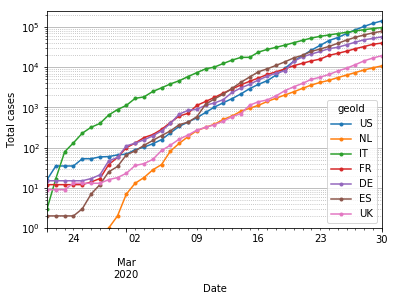

In [10]:
# Standard plot: Number of cases vs date
p=Ncases[Interest].plot(logy=True, marker=".")
p.set_ylim(1,)
p.set_xlim(startdate,)
p.set_xlabel("Date")
p.set_ylabel("Total cases")
p.grid('on', which='major', axis='y')
p.grid('on', which='minor', axis='y', linestyle='dotted')

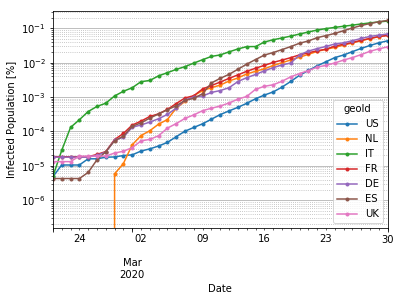

In [11]:
# Infection rate vs date
p=Rinf.plot(logy=True, marker=".")
p.set_xlim(startdate,)
p.set_xlabel("Date")
p.set_ylabel("Infected Population [%]")
p.grid('on', which='major', axis='y')
p.grid('on', which='minor', axis='y', linestyle='dotted')

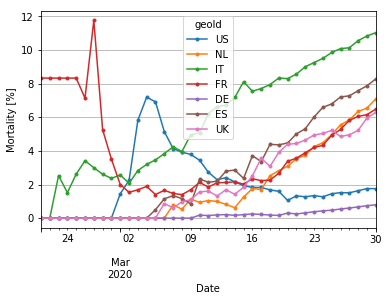

In [12]:
# Mortality vs date
p=Rdeath.plot(marker=".")
p.set_xlim(startdate,)
p.set_xlabel("Date")
p.set_ylabel("Mortality [%]")
p.grid('on', which='major', axis='y')

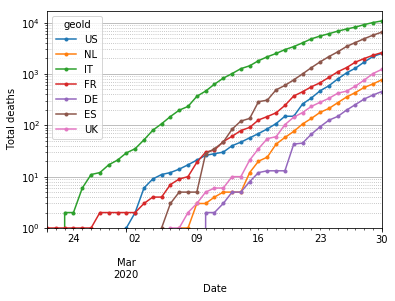

In [13]:
# Total deaths vs date
# This could be a better proxy to real infection rate than reported cases,
# as the unreported numebr of deaths varies a lot less with time and
# with country compared to the unreported number of cases
p=Ndeaths[Interest].plot(logy=True, marker=".")
p.set_ylim(1,)
p.set_xlim(startdate,)
p.set_xlabel("Date")
p.set_ylabel("Total deaths")
p.grid('on', which='major', axis='y')
p.grid('on', which='minor', axis='y', linestyle='dotted')

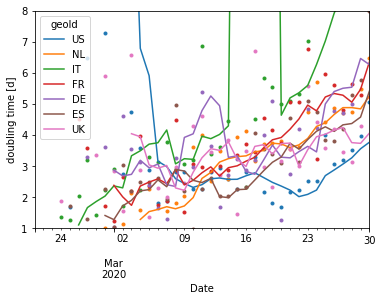

In [14]:
# Doubling time vs date
# Data is of course _very_ noisy. Plot data as dots, overplot 5-day boxcar average

# replace zeros with NaN to ignore data and avoid warnings
Tdouble=np.log(2)/np.log(1+cases/Ncases.replace({0:np.nan}).shift(1)).replace({0:np.nan})
Tdouble_smooth=Tdouble.rolling(5).mean()

p=Tdouble[Interest].plot(style=".", legend=False)
p.set_prop_cycle(None)
p=Tdouble_smooth[Interest].plot(ax=p)
p.set_ylim(1,8)
p.set_xlim(startdate,)
p.set_xlabel("Date")
p.set_ylabel("doubling time [d]");

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


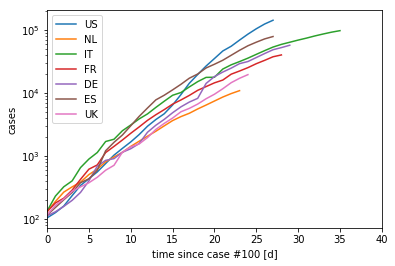

In [15]:
# PLot cases since case #100
p=Ncase100[Interest].plot(logy=True)
#p.legend(Countries.loc[Interest].values)
Days_IT=Ncase100.IT.index[Ncase100.IT==max(Ncase100.IT)].tolist().pop()
p.set_xlim([0,Days_IT+5])
# p.grid('on', which='major', axis='y')
# p.grid('on', which='minor', axis='y', linestyle='dotted')
p.set_ylabel("cases")
p.set_xlabel("time since case #100 [d]");

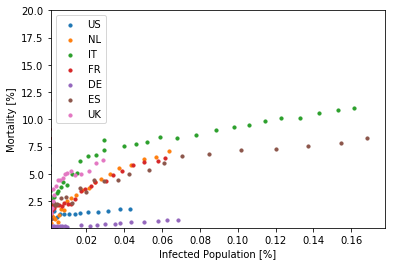

In [16]:
# Question: Why do some countries have a higher mortality rate than others?
# Is it number of hospital beds? ICU beds? Population structure?
# Hypothesis: it has something to do with care, not with population
# Experiment: plot mortality vs infection rate. What is the correlation?
# Result: Yes, there are clear correlations. Interesting: Countries group together following distinct
# trajectories, but there seem to be different trajectories that countries take
# Does not seem immediately obvious, it is NOT a correlation with hospital beds. France clusters with
# Netherlands and Spain, not with Germany and Austria, despite high number of per capita hospital beds
# New hypothesis: Mortality is the same everywhere, we're seeing effects of unreported cases.
# High rate of unreported cases seems like a high mortality.
# UK clusters with Italy at high mortality, both are only testing severe cases. Germany and Austria cluster
# at very low mortality and have very extensive testing regimes. But why is South Korea not with Germany?
# Corollary if true: Ndeaths may be a better proxy for total number of cases than #Ncases!

for geoId in Rinf:
    #plt.scatter(Rinf[geoId],Rdeath[geoId], s=Hbeds[geoId]/(Population[geoId]*1000)*5, label=geoId)
    plt.scatter(Rinf[geoId],Rdeath[geoId], s=10, label=geoId)

plt.legend()
# plt.xscale('log')
# plt.yscale('log')
plt.xlim(0.001,)
plt.ylim(0.05,20)
plt.xlabel("Infected Population [%]")
plt.ylabel("Mortality [%]");


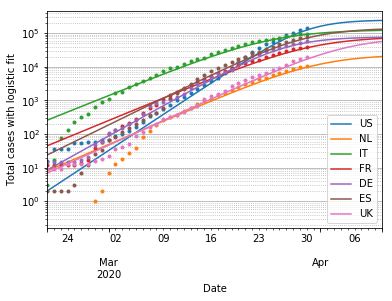

In [17]:
# Experimet with logistics fits to cases since 100th case
# NB predictions are shaky and dangerous! That's why the "real" epidemiologists don't
# go on record with simple logistics fits...
startpar=[2,25,1e4]
p=plt.figure()
ax=p.add_subplot(111)
i=-1;

for geoId in Interest:
    i+=1
    pf=df_fit(logistic_raw, Ncases[geoId], startpar)
    logistic(pd.date_range('2020-02-15', '2020-04-10'), pf, geoId).plot(ax=ax, logy=True, color="C{}".format(i))
    Ncases[geoId].plot(ax=ax, logy=True, style='.', label=geoId, color="C{}".format(i))

ax.set_xlim(startdate,)
ax.set_xlabel("Date")
ax.set_ylabel("Total cases with logistic fit")
ax.grid('on', which='major', axis='y')
ax.grid('on', which='minor', axis='y', linestyle='dotted')

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


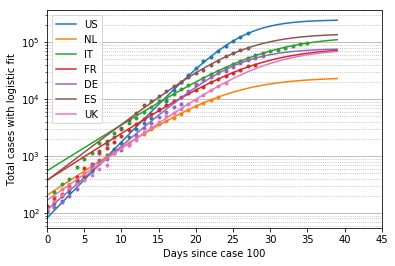

In [18]:
# Experimet with logistics fits to cases since 100th case
# NB predictions are shaky and dangerous! That's why the "real" epidemiologists don't
# go on record with simple logistics fits...
startpar=[2,25,1e4]
p=plt.figure()
ax=p.add_subplot(111)
i=-1;

for geoId in Interest:
    i+=1
    pf=df_fit(logistic_raw, Ncase100[geoId], startpar)
    logistic(np.arange(0,40), pf, geoId).plot(ax=ax, logy=True, color="C{}".format(i))
    Ncase100[geoId].plot(ax=ax, logy=True, style='.', label=geoId, color="C{}".format(i))

ax.set_xlim(0,45)
ax.set_xlabel("Days since case 100")
ax.set_ylabel("Total cases with logistic fit")
ax.grid('on', which='major', axis='y')
ax.grid('on', which='minor', axis='y', linestyle='dotted')